In [1]:
if __name__ == '__main__':
# Load necessary packages
    import ssms
    import lanfactory 
    import os
    import numpy as np
    from copy import deepcopy
    import torch
    import pandas as pd
    import matplotlib.pyplot as plt    

    import torch
    import torch.nn as nn
    import uuid
    # from .torch_config import TorchConfig
    # from .mlp_model_class import TorchMLP
    # import hddm
    

In [2]:

class TorchMLP(nn.Module):
    def __init__(
        self,
        network_config=None,
        input_shape=10,
        save_folder=None,
        generative_model_id="ddm",
    ):
        super(TorchMLP, self).__init__()
        if generative_model_id is not None:
            self.model_id = uuid.uuid1().hex + "_" + generative_model_id
        else:
            self.model_id = None

        self.save_folder = save_folder
        self.input_shape = input_shape
        self.network_config = network_config
        self.activations = {"relu": torch.nn.ReLU(), "tanh": torch.nn.Tanh()}
        self.layers = nn.ModuleList()

        self.layers.append(
            nn.Linear(input_shape, self.network_config["layer_sizes"][0])
        )
        self.layers.append(self.activations[self.network_config["activations"][0]])
        # print(self.network_config['activations'][0])
        for i in range(len(self.network_config["layer_sizes"]) - 1):
            self.layers.append(
                nn.Linear(
                    self.network_config["layer_sizes"][i],
                    self.network_config["layer_sizes"][i + 1],
                )
            )
            # print(self.network_config['activations'][i + 1])
            if i < (len(self.network_config["layer_sizes"]) - 2):
                self.layers.append(
                    self.activations[self.network_config["activations"][i + 1]]
                )
            else:
                # skip last activation since
                pass
        self.len_layers = len(self.layers)

    def forward(self, x):
        for i in range(self.len_layers - 1):
            x = self.layers[i](x)
        return self.layers[-1](x)

# except:
#     print(
#         "Error loading pytorch capabilities. Neural network functionality cannot be used."
#     )


class LoadTorchMLPInfer:
    def __init__(self, model_file_path=None, network_config=None, input_dim=None):
        torch.backends.cudnn.benchmark = True
        self.dev = (
            torch.device("cuda")
            if torch.cuda.is_available()
            else torch.device("cpu")
        )

        print('dev:', self.dev)

        self.model_file_path = model_file_path
        self.network_config = network_config
        self.input_dim = input_dim

        self.net = TorchMLP(
            network_config=self.network_config,
            input_shape=self.input_dim,
            generative_model_id=None,
        )
        self.net.load_state_dict(
            torch.load(self.model_file_path, map_location=self.dev)
        )
        self.net.to(self.dev)
        # AF Q: IS THIS REDUNDANT NOW?

        self.net.eval()

    @torch.no_grad()
    def predict_on_batch(self, x=None):
        return self.net(torch.from_numpy(x).to(self.dev)).cpu().numpy()




dev: cpu
0      -1.0
1      -1.0
2      -1.0
3      -1.0
4      -1.0
       ... 
1995    1.0
1996    1.0
1997    1.0
1998    1.0
1999    1.0
Name: choice, Length: 2000, dtype: float32


C:\Users\horiz\AppData\Local\Temp\ipykernel_16592\3292323189.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rt'].iloc[:1000] = np.linspace(5, 0, 1000)
C:\Users\horiz\AppData\Local\Temp\ipykernel_16592\3292323189.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['choice'].iloc[:1000] = -1
C:\Users\horiz\AppData\Local\Temp\ipykernel_16592\3292323189.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['choice'].i

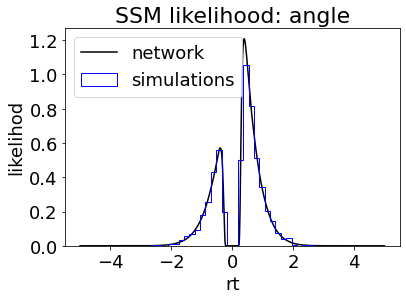

In [4]:

# except:
#     print("HDDM: pytorch module seems missing. No LAN functionality can be loaded.")

ddm_model = "angle"
n_ddm_parameter = len(ssms.config.model_config[ddm_model]['params'])
# path = 'train_LAN/{}/data/'.format(ddm_model)

path = 'TrainedLANs/'

network_path_list = os.listdir(path)
network_file_path = [path + file_ for file_ in network_path_list if 'state_dict' in file_][0]

import pickle 
network_config = pickle.load(open('TrainedLANs/248c94cca33e11ecb947ac1f6bfea5a4_training_data_angle_torch__network_config.pickle', 'rb'))

network = LoadTorchMLPInfer(model_file_path = network_file_path,
                                                network_config = network_config,
                                                input_dim = n_ddm_parameter + 2)

#%% 9
# Two ways to call the network
# Direct call --> need tensor input
# direct_out = network(torch.from_numpy(np.array([1, 0.5, 0.5, 0.5, 1, 0.65, 1], dtype  = np.float32)))
# print('direct call out: ', direct_out)

# predict_on_batch method
# predict_on_batch_out = network.predict_on_batch(np.array([1, 1.5, 0.5, 1.0, 0.1, 0.65, 1], dtype  = np.float32))
# print('predict_on_batch out: ', predict_on_batch_out)
#%% 10
# show likeliood
if ddm_model == "ddm" :
    data_col = ['v', 'a', 'z', 't', 'rt', 'choice']

    data = pd.DataFrame(np.zeros((2000, n_ddm_parameter + 2), 
                        dtype = np.float32), 
                        columns = data_col)
    data['v'] = 0.5 # drift rate
    data['a'] = 0.75 # threshold
    data['z'] = 0.5 # bias
    data['t'] = 0.2 # nondesicion time
    data['rt'].iloc[:1000] = np.linspace(5, 0, 1000)
    data['rt'].iloc[1000:] = np.linspace(0, 5, 1000)
    data['choice'].iloc[:1000] = -1
    data['choice'].iloc[1000:] = 1
    print(data['choice'])

elif ddm_model == "angle":
    data = pd.DataFrame(np.zeros((2000, n_ddm_parameter + 2), 
                dtype = np.float32), 
                columns = ['v', 'a', 'z', 't', 'theta','rt', 'choice'])
    data['v'] = 0.5 # drift rate
    data['a'] = 0.75 # threshold
    data['z'] = 0.5 # bias
    data['t'] = 0.2 # nondesicion time
    data['theta'] = 0.1 # linear boundary, the angle of boundary
    data['rt'].iloc[:1000] = np.linspace(5, 0, 1000)
    data['rt'].iloc[1000:] = np.linspace(0, 5, 1000)
    data['choice'].iloc[:1000] = -1
    data['choice'].iloc[1000:] = 1
    print(data['choice'])

#%% 11
# Network predictions
predict_on_batch_out = network.predict_on_batch(data.values.astype(np.float32))

# Simulations
from ssms.basic_simulators import simulator 
sim_out = simulator(model = ddm_model, 
                    theta = data.values[0, :-2],
                    n_samples = 2000)
#%% 12
data_rt = np.array(data['rt'] * data['choice'])
# Plot network predictions
# plt.plot(data['rt'] * data['choice'], np.exp(predict_on_batch_out), color = 'black', label = 'network')
plt.plot(data_rt, np.exp(predict_on_batch_out), color = 'black', label = 'network')
# Plot simulations
plt.hist(sim_out['rts'] * sim_out['choices'], bins = 30, histtype = 'step', label = 'simulations', color = 'blue', density  = True)
plt.legend(fontsize=18)
plt.title('SSM likelihood: {}'.format(ddm_model), fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('rt', fontsize=18)
plt.ylabel('likelihod', fontsize=18)
plt.show()
